# 1.三个代码的合并与优化

> `000tickets_plot.py` <br>
> `001hspeed_vp.py` <br>
> `002get_stations.py` <br>

E:\TutoData\cn12306

## 某一站点一周时间内的数据可视化

In [10]:
df1=pd.DataFrame(np.random.rand(10,2),columns=['x column','y column'])
df2=pd.DataFrame(np.random.rand(10,2),columns=['x column','y column'])
df3=pd.DataFrame(np.random.rand(10,2),columns=['x column','y column'])
df4=pd.DataFrame(np.random.rand(10,2),columns=['x column','y column'])

In [13]:
for i in range(7):
    orginal_data = 'C:/12306data/HuNing-2016-12-'+str(i+21)+'.csv'
    print orginal_data

C:/12306data/HuNing-2016-12-21.csv
C:/12306data/HuNing-2016-12-22.csv
C:/12306data/HuNing-2016-12-23.csv
C:/12306data/HuNing-2016-12-24.csv
C:/12306data/HuNing-2016-12-25.csv
C:/12306data/HuNing-2016-12-26.csv
C:/12306data/HuNing-2016-12-27.csv


In [1]:
import numpy

a = numpy.array([1,2])

a[:,0]

IndexError: too many indices for array

In [ ]:
import numpy

a = numpy.array([1,2])

a[:,0]

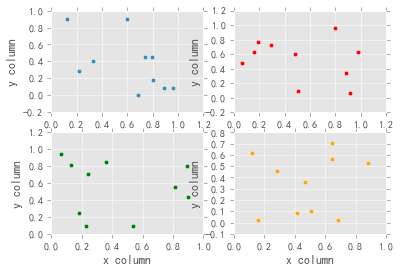

In [12]:
fig,axes=plt.subplots(nrows=2,ncols=2)
df1.plot(kind='scatter',x='x column',y='y column',ax=axes[0,0])
df2.plot(kind='scatter',x='x column',y='y column',ax=axes[0,1],color='red')
df3.plot(kind='scatter',x='x column',y='y column',ax=axes[1,0],color='green')
df4.plot(kind='scatter',x='x column',y='y column',ax=axes[1,1],color='orange')

In [ ]:
# -*- coding:utf-8 -*-
import pandas as pd
import arrow
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# 关掉warnnings
import warnings
warnings.filterwarnings("ignore")


class DataPlot(object):
	
	# 构造函数，定义所要使用的参数
	def __init__(self,orginal_data,orginal_station,station_to_plot):
		self.orginal_data = orginal_data
		self.orginal_station = orginal_station
		self.station_to_plot = station_to_plot

	def data_to_use(self):
		# 导入数据
		df = pd.read_csv(self.orginal_data,encoding='utf-8')
		df.columns = [u'train_no',u'station_train_code', u'from_station_name',u'to_station_name',
		                    u'start_time',
		                    u'swz_num',
		                    u'tz_num',
		                    u'zy_num',
		                    u'ze_num',
		                    u'wz_num',
		              		u'record_date',
		              		u'record_time',]

		# 筛选出发车时间在06:00-23:00的车次
		df2 = df[(df['start_time'].str.contains("0[6-9]:|1[0-9]:|2[0-3]:"))]

		#增加一列，记录发车前30分钟数据
		df2['start_time_before30m'] = df2['start_time'].apply(lambda x: arrow.get(x, 'HH:mm').replace(minutes=-30).format('HH:mm'))

		# 筛选出：发车前30分钟时间==记录时间
		df3 = df2[df2['start_time_before30m'] == df2['record_time']]

		# 增加一列，记录出发站，到达站数据，并以列表形式存储
		df3['from_to'] = df3['from_station_name'] + ',' +df3['to_station_name']
		df3['from_to'] = df3['from_to'].str.split(',')
		return df3

		# df3为最终筛选数据
		############################

	def get_stations(self):
		
		#获取各车次区间情况
		data_to_use = self.data_to_use()
		df = pd.read_csv(self.orginal_station,encoding='utf-8')
		df.columns=['station_name','train_no']
		df['station_name'] = df['station_name'].apply(lambda x: x.replace(u'[',u'').replace(u']',u'').replace(' ','').split(','))
		df['station_interval'] = df['station_name'].apply(lambda x: map(list, zip(x[:-1], x[1:])))

		# df_SH_NJ是沪宁所有车次相邻站点信息。
		df_tickets_com = pd.merge(data_to_use,df,on='train_no')
		df_tickets_com = df_tickets_com[df_tickets_com.apply(lambda x: x['from_to'] in x['station_interval'], axis=1)]
		return df_tickets_com

	def main(self):
		
		# 主函数，输出可供可视化的df

		dff = self.get_stations()
		
		# 判断区间是否是相邻区间
		df_to = dff[dff['to_station_name'].isin(self.station_to_plot)]
		df_from = dff[dff['from_station_name'].isin(self.station_to_plot)]
		

		# 计算上游区间余票数据
		df_to['tickets_sum_to'] = df_to['swz_num']+\
		df_to['tz_num']+df_to['wz_num']+df_to['ze_num']+\
		df_to['zy_num']

		# 计算下游区间余票数据
		df_from['tickets_sum_from'] = df_from['swz_num']+\
		df_from['tz_num']+df_from['wz_num']+df_from['ze_num']+\
		df_from['zy_num']

		# 数据融合后判断上下客情况
		df = pd.merge(df_to,df_from, on = 'train_no')
		df['tickets'] = df['tickets_sum_to'] - df['tickets_sum_from']

		# df['start_time_y'] = df['start_time_y'].\
		# apply(lambda x: arrow.get(str(x),'YY-MM-DD HH:mm:ss').format('HH:mm'))
		
		# 导出可用数据
		df_to_plot = df[['tickets','start_time_y']]
		return df_to_plot

if __name__ == '__main__':
	
	######## 参数集中在此 #########
	
	orginal_station = './py/data/SH-NJ-train_names.csv'    #录入站点列表
	station_to_plot =  [u'苏州',u'苏州北',u'苏州园区',u'苏州新区']
	for i in range(21,28):
		plt.subplot(7, 1, i-20)
		orginal_data = r'C:/12306data/HuNing-2016-12-'+str(i)+'.csv'

	# station_to_plot =  [u'昆山南']
	################################

	# 实例化类
		data_plot = DataPlot(orginal_data,orginal_station,station_to_plot)
		
		# 传递可用数据
		data_to_plot = data_plot.main()
		
		# 所要使用的plt样式
		plt.style.use('ggplot')

		dmt= data_to_plot.sort_values(by='start_time_y')
		plt.plot_date(y=dmt['tickets'], x =dmt['start_time_y'])
		plt.xlabel(u'时 间(2016-12-'+str(i)+u' 06:00—23:00)',size=10)
		plt.ylabel(u'上下客流量值（单位：人）',size=10)
		plt.title(u'苏州地区站点（上海——南京）\n',size=10)
		# plt.show()
	plt.tight_layout()
# 		print('finished!')

In [5]:
print u'时 间(2016-12-'+str(21)+u' 06:00—23:00)'

时 间(2016-12-21 06:00—23:00)


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)

df1.plot(ax=axes[0,0],)
df2.plot(ax=axes[1,0],)

| 额外全额 | e'q'we'q'w | q'e'q'we'e'q'we |   |   |
|----------|------------|-----------------|---|---|
| q'we'q'w | q'we       | e'q'we          |   |   |
| e'w'q'w  | e'w'w'q'e  | q'we'w'q        |   |   |
| e'q'we   | q'we'q'w   | w'q'e'q'w       |   |   |
| w'q'e'q  | e'w'q'e    | q'we'q'w        |   |   |